# $f_{1}^{``}$ Tests and Variations on some Data-Sets
# [Index for the evaluation of the general photometric performance of photometers. Optics Express, 26(14), 18633-18643](https://doi.org/10.1364/OE.26.018633)

In [1]:
# Use some packages
import luxpy as lx
import math
import numpy as np
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift, rfft, irfft, rfftfreq
from scipy.signal import resample
import matplotlib.pyplot as plt
%matplotlib inline

from empir19nrm02 import _RES, _SPD
from empir19nrm02.f1prime import py_f1PrimeGlx, py_f1PrimeG
from empir19nrm02.tools import plotSelectedSPD, plotYxy, plotHist, plotCorrMatrixSamll

In [2]:
# modified from https://stackoverflow.com/questions/36534035/pad-0s-of-numpy-array-to-nearest-power-of-two
def NextPowerOfTwo(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log(number,2))

def PadLeft(arr, offset=0):
    nextPower = NextPowerOfTwo(len(arr))+offset
    deficit = int(math.pow(2, nextPower) - len(arr))
    arr = np.concatenate((arr, np.zeros(deficit, dtype=arr.dtype)))
    return arr

def checkAbs( data):
    return data if not makeAbs else abs(data)

image_number =1
figExtension = '.png'

def gen_new_image():
    #image_number+=1
    fig, ax = plt.subplots( figsize=(14,10))
    return [fig, ax]

def close_image( fig, ax, xlabel='xlabel', ylabel='ylabel', title='title', save=image_number):
    ax.legend()
    ax.set_xlabel( xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title( title)
    if image_number:
        fig.savefig( 'Opex_fig' + str(image_number) + figExtension)

## Read some detectors (_RES) data (collection from CIES025)

In [3]:
CIES025_vldetectors = _RES['CIES025_VLDetectors']['S']['data'].copy()
CIES025_vldetectors_info = _RES['CIES025_VLDetectors']['S']['info'].copy()

print( 'CIES025_VLDetector size:', CIES025_vldetectors.shape)
print( 'CIES025_VLDetector Info size:', CIES025_vldetectors_info.shape)

CIES025_VLDetector size: (122, 81)
CIES025_VLDetector Info size: (121, 3)


## Use the cutoff frequency from the Lit as default (0.003 1/nm)
## Select a specific detector from the set.

In [4]:
dCutOff = 0.006
position = 10

## Use the standard wavelength scale ($\Delta\lambda = 5 \mathrm{nm}$) from the original data (Label = 'Org') set and
## the interpolated dataset (Label = 'OrgI') with ($\Delta\lambda_{\mathrm{I}} = 1 \mathrm{nm}$)
## Interpolation with resample from numpy (also using FFT)

In [5]:
# generate Detector and wavelength scale information
vlDetectorSelect = CIES025_vldetectors[position, :].copy()
wlScale = CIES025_vldetectors[0, :]
[vlDetectorSelectI, wlScaleI] = resample( vlDetectorSelect, wlScale.shape[0]*5, wlScale)
[f1p, _] = py_f1PrimeG(wlScale, vlDetectorSelect)
[f1pI, _] = py_f1PrimeG(wlScaleI, vlDetectorSelectI)
[f1pTest, deltaVector] = py_f1PrimeG(wlScale, vlDetectorSelect, dCutOff=dCutOff)
[f1pTestI, deltaVectorI] = py_f1PrimeG(wlScaleI, vlDetectorSelectI, dCutOff=dCutOff)

### $f_{1}^{`}$ for the original and the interpolated function
### This means the $f_{1}^{``}$ depend also on the wavelength resolution!!!!

In [6]:
print('$f_{1}^{`}$=', f1p)
print('$f_{1, \mathrm{I}}^{`}$=', f1pI)
print('$f_{1}^{``}$=', f1pTest)
print('$f_{1, \mathrm{I}}^{``}$=', f1pTestI)

$f_{1}^{`}$= 0.05971628252425652
$f_{1, \mathrm{I}}^{`}$= 0.05948613092053343
$f_{1}^{``}$= 6.137423103513273e-05
$f_{1, \mathrm{I}}^{``}$= 6.694011814986614e-05


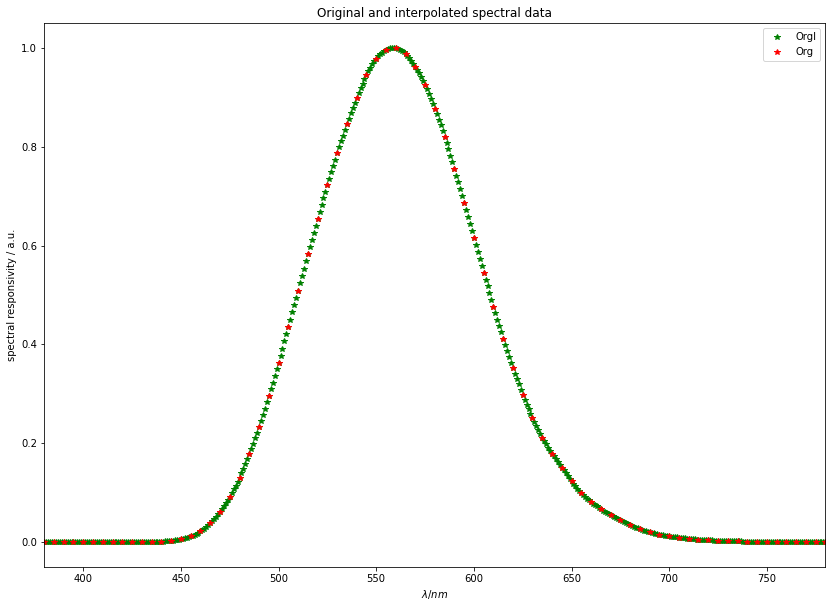

In [7]:
[fig, ax] = gen_new_image()
ax.plot(wlScaleI, vlDetectorSelectI,'g*', label='OrgI')
ax.plot(wlScale, vlDetectorSelect,'r*', label='Org')
ax.set_xlim(left=380, right=780)
close_image( fig, ax, xlabel='$\lambda / nm$', ylabel='spectral responsivity / a.u.', title='Original and interpolated spectral data', save=image_number)
image_number +=1

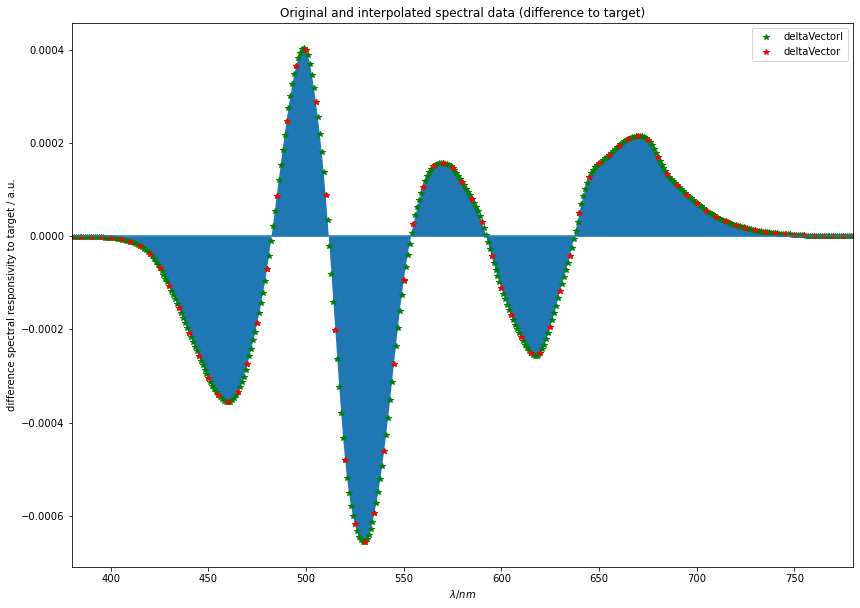

In [8]:
[fig, ax] = gen_new_image()
ax.plot(wlScaleI, deltaVectorI,'g*', label='deltaVectorI')
ax.plot(wlScale, deltaVector,'r*', label='deltaVector')
ax.set_xlim(left=380, right=780)
ax.axhline(0)
ax.fill_between(wlScaleI, deltaVectorI)
close_image( fig, ax, xlabel='$\lambda / nm$', ylabel='difference spectral responsivity to target / a.u.', title='Original and interpolated spectral data (difference to target)', save=image_number)
image_number +=1

#### remove the mean value from the data ($f_{\lambda}=0$)

In [9]:
zeroNull = True

#### plot the data as absolute values

In [10]:
makeAbs = True

#### ZeroPadding?
#### offsetPowerOf2 = 0    normal ZeroPadding to the next power of 2
#### offsetPowerOf2 = N    increase the power of two for the zero padding by N

In [11]:
offsetPowerOf2 = 0

In [12]:
# caculate the resolution and scales for the original data and the interpolated data
res =wlScale.shape[0]
deltaLambda = np.mean(np.diff(wlScale))
resI = wlScaleI.shape[0]
deltaLambdaI = np.mean(np.diff(wlScaleI))


print('NextPowerOfTwo', res, NextPowerOfTwo(res))
print('NextPowerOfTwoI', resI, NextPowerOfTwo(resI))

deltaVectorFFT = rfft(deltaVector)
deltaVectorIFFT = rfft(deltaVectorI)

NextPowerOfTwo 81 7
NextPowerOfTwoI 405 9


In [13]:
deltaVectorZeroPadding=PadLeft(deltaVector, offsetPowerOf2)
resZeroPadding = deltaVectorZeroPadding.shape[0]
wlScaleZeroPadding = np.arange(0, resZeroPadding)*deltaLambda + wlScale[0]

deltaVectorIZeroPadding=PadLeft(deltaVectorI, offsetPowerOf2)
resIZeroPadding = deltaVectorIZeroPadding.shape[0]
wlScaleIZeroPadding = np.arange(0, resIZeroPadding)*deltaLambdaI + wlScaleI[0]

deltaVectorFFTZeroPadding = rfft(deltaVectorZeroPadding)
deltaVectorIFFTZeroPadding = rfft(deltaVectorIZeroPadding)

# get the frequency list from the FFT scale
wlFrequencies = rfftfreq(res, deltaLambda)
wlFrequenciesZeroPadding = rfftfreq(resZeroPadding, deltaLambda)
wlFrequenciesI = rfftfreq(resI, deltaLambdaI)
wlFrequenciesIZeroPadding = rfftfreq(resIZeroPadding, deltaLambdaI)

if zeroNull:
    # Attention: fftshift
    deltaVectorFFTZeroPadding[np.where(wlFrequenciesZeroPadding == 0)] = 0;
    deltaVectorFFT[np.where(wlFrequencies == 0)] = 0;
    deltaVectorIFFTZeroPadding[np.where(wlFrequenciesIZeroPadding == 0)] = 0;
    deltaVectorIFFT[np.where(wlFrequenciesI == 0)] = 0;


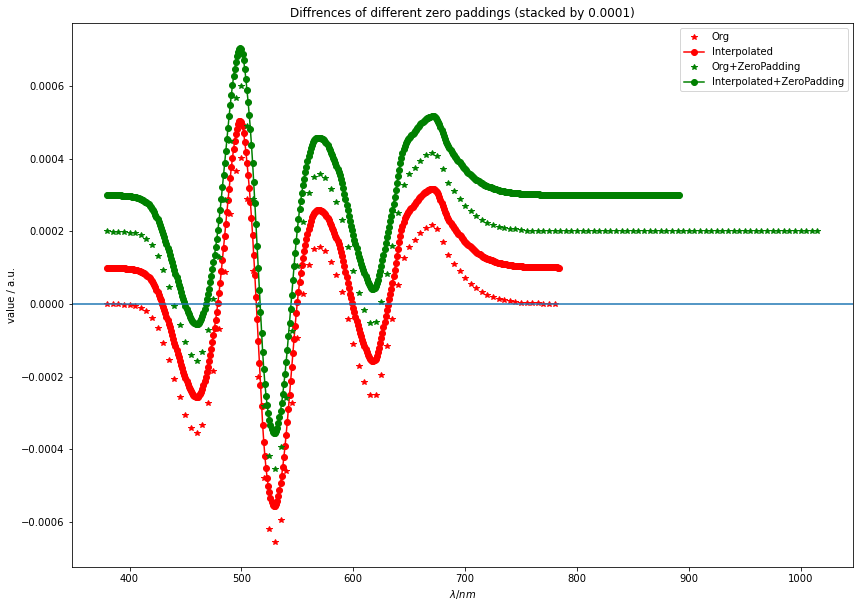

In [14]:
[fig, ax] = gen_new_image()
ax.plot(wlScale, deltaVector,'r*', label='Org')
ax.plot(wlScaleI, deltaVectorI+0.0001,'ro-', label='Interpolated')
ax.plot(wlScaleZeroPadding, deltaVectorZeroPadding+0.0002,'g*', label='Org+ZeroPadding')
ax.plot(wlScaleIZeroPadding, deltaVectorIZeroPadding+0.0003,'go-', label='Interpolated+ZeroPadding')
ax.axhline(0)
close_image( fig, ax, xlabel='$\lambda / nm$', ylabel='value / a.u.', title='Diffrences of different zero paddings (stacked by 0.0001)', save=image_number)
image_number +=1


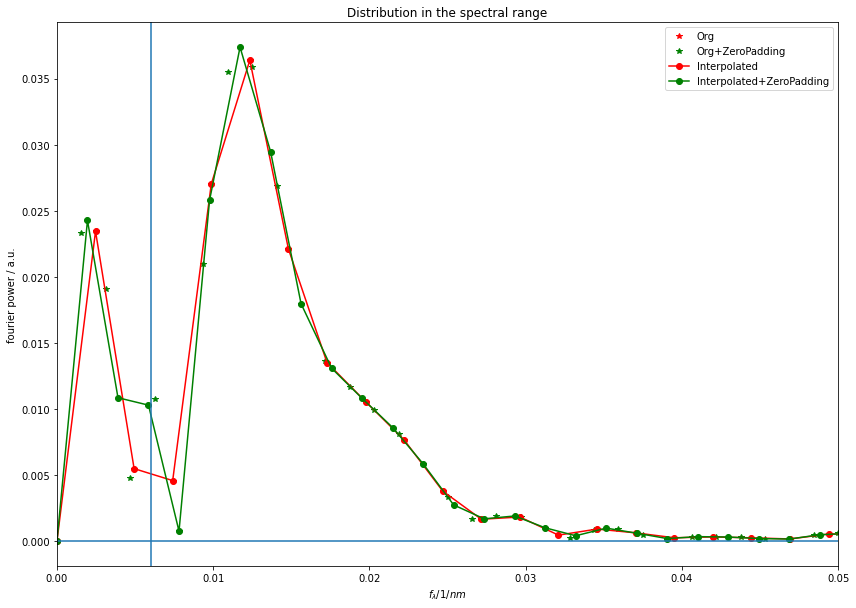

In [15]:
[fig, ax] = gen_new_image()
ax.plot(wlFrequencies, checkAbs( deltaLambda*deltaVectorFFT),'r*', label='Org')
ax.plot(wlFrequenciesZeroPadding, checkAbs( deltaLambda*deltaVectorFFTZeroPadding),'g*', label='Org+ZeroPadding')
ax.plot(wlFrequenciesI, checkAbs( deltaLambdaI*deltaVectorIFFT),'ro-', label='Interpolated')
ax.plot(wlFrequenciesIZeroPadding, checkAbs( deltaLambdaI*deltaVectorIFFTZeroPadding),'go-', label='Interpolated+ZeroPadding')
ax.axvline(dCutOff)
ax.set_xlim(left=0, right=0.05)
ax.axhline(0)
close_image( fig, ax, xlabel='$f_{\lambda} / 1/nm$', ylabel='fourier power / a.u.', title='Distribution in the spectral range', save=image_number)
image_number +=1

# Summary
From the original data with $N$ wavelength steps of $\Delta\lambda$ we get a wavelength range $\lambda_{\mathrm{p}}$

Furthermore we get a periodification frequecny of $f_{\mathrm{p}}=N f_{0}$

Meaning that our frequency step in the fourier space is $f_{\mathrm{0}}=\frac{1}{N\Delta\lambda}$

### That means if we change $\Delta\lambda$ and keep $\lambda_{\mathrm{p}}$ constant (simply using the same wavelength range to observe)
### we get the same steps in the wavelenth range $f_{\mathrm{0}}$ (see comparison of 5nm and 1nm data, compare Org and Interpolated)

Adding more values $N$ (e.g. using ZeroPadding) increases the wavelength range $\lambda_{\mathrm{p}}$ and could make the frequency steps smaller.
However, using ZeroPadding we will not add any information. We will simply interpolate our measurement data (multiplying the wavelength domain with a
rectangle (width $\lambda_{\mathrm{p}}$) and therefor convolute the spectral values with the associated Si()-Function.

In [16]:
print('Frequency resolution (1/nm):', wlFrequencies[1])
print('Frequency resolution with Interpolation (1/nm):', wlFrequenciesI[1])

print('Steps to cutoff:' , dCutOff/wlFrequenciesI[1])

Frequency resolution (1/nm): 0.0024691358024691358
Frequency resolution with Interpolation (1/nm): 0.0024691358024691358
Steps to cutoff: 2.43


That means we use only the very first frequency component for the analysis with the current Opex settings.
This will result in the following comparison from the original deltaVectorFunction and the back transformated one.

The conclusion is, that this will not represent the spectral deviaions anymore.

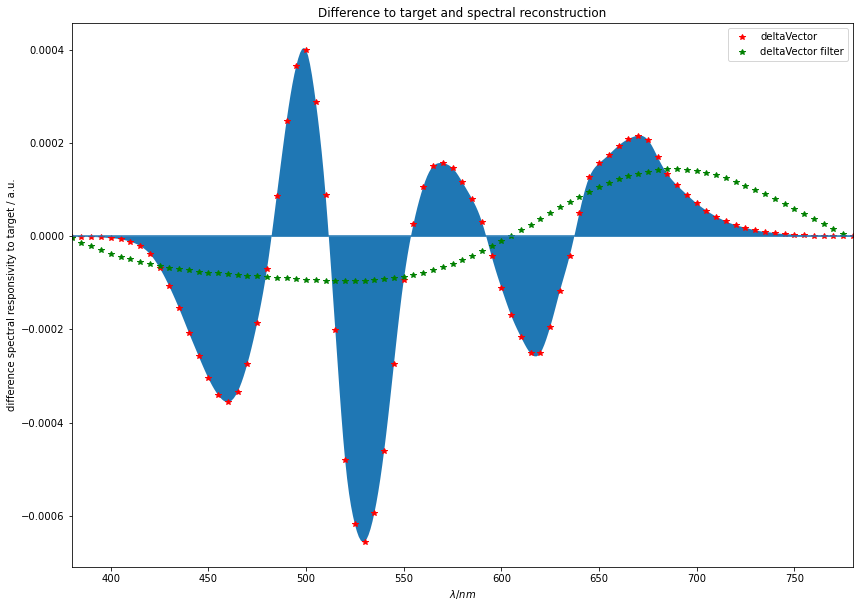

In [17]:
deltaVectorFFTFilter = deltaVectorFFT.copy()
deltaVectorFFTFilter[np.where(wlFrequencies >= dCutOff)]=0
deltaVectorR = irfft( deltaVectorFFTFilter)

[fig, ax] = gen_new_image()
ax.plot(wlScale, deltaVector,'r*', label='deltaVector')
ax.plot(wlScale[0:deltaVectorR.shape[0]], deltaVectorR,'g*', label='deltaVector filter')
ax.set_xlim(left=380, right=780)
ax.axhline(0)
ax.fill_between(wlScaleI, deltaVectorI)
close_image( fig, ax, xlabel='$\lambda / nm$', ylabel='difference spectral responsivity to target / a.u.', title='Difference to target and spectral reconstruction', save=image_number)
image_number +=1

Whatever is correlating with the integral of the green curve. It has nothing to do with the deviation of the original curve to the target funcktion.

# For explanation only:

Some zero paddings, to show the influence.

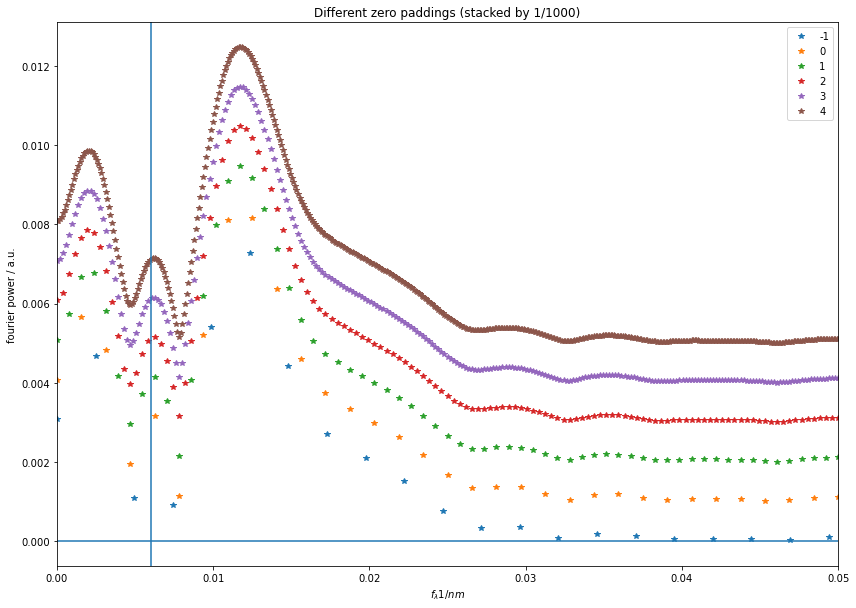

In [18]:
[fig, ax] = gen_new_image()

for zp in np.arange(-1, 5, 1):
    if zp >= 0:
        deltaVectorZeroPaddingH=PadLeft(deltaVector, zp)
    else:
        deltaVectorZeroPaddingH=deltaVector

    resZeroPaddingH = deltaVectorZeroPaddingH.shape[0]
    wlScaleZeroPaddingH = np.arange(0, resZeroPaddingH)*deltaLambda + wlScale[0]
    deltaVectorFFTZeroPaddingH = rfft(deltaVectorZeroPaddingH)
    wlFrequenciesH = rfftfreq(resZeroPaddingH, deltaLambda)

    ax.plot(wlFrequenciesH, checkAbs( deltaVectorFFTZeroPaddingH)+(zp+1)/1000, "*", label=zp)

ax.axvline(dCutOff)
ax.set_xlim(left=0, right=0.05)
ax.axhline(0)
close_image( fig, ax, xlabel='$f_{\lambda} 1/ nm$', ylabel='fourier power / a.u.', title='Different zero paddings (stacked by 1/1000)', save=image_number)
image_number +=1

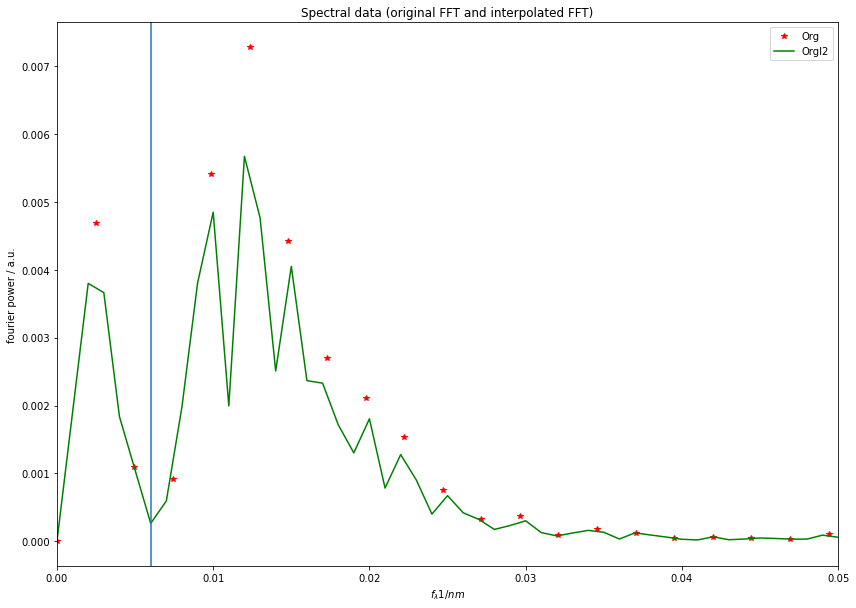

In [19]:
# How many values we will need from the interpolation
wlFrequenciesI2 = lx.getwlr([0, 1/(2*deltaLambda), 0.001])
deltaVectorFFTI2=np.interp(wlFrequenciesI2, wlFrequencies, deltaVectorFFT)

[fig, ax] = gen_new_image()
ax.plot(wlFrequencies, checkAbs(deltaVectorFFT) ,'r*', label='Org')
ax.plot(wlFrequenciesI2, checkAbs( deltaVectorFFTI2),'g-', label='OrgI2')
ax.axvline(dCutOff)
ax.set_xlim(left=0, right=0.05)
close_image( fig, ax, xlabel='$f_{\lambda} 1/ nm$', ylabel='fourier power / a.u.', title='Spectral data (original FFT and interpolated FFT)', save=image_number)
image_number +=1


### Attention: We interpolate the complex FFT data and show the absolute values of these data.

The first makes normally no sense.

The second give a interpolation not connecting the original points which is somehow unusual.

### The original publicationinterpolates the absolute values of the FFT data only, but in this case a backtransformation is not possible.

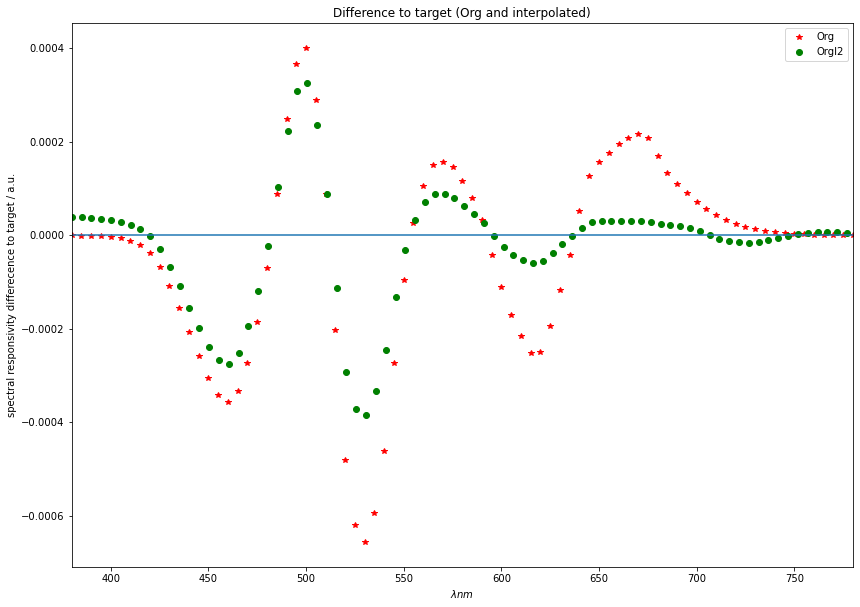

In [20]:
# How many values we will need from the interpolation
deltaVectorI2=irfft( deltaVectorFFTI2)
wlScaleI2 = np.linspace( wlScale[0], wlScale[0]+deltaVectorI2.shape[0]*deltaLambda, num = deltaVectorI2.shape[0])

[fig, ax] = gen_new_image()
ax.plot(wlScale, deltaVector,'r*', label='Org')
ax.plot(wlScaleI2, deltaVectorI2,'go', label='OrgI2')
ax.set_xlim(left=380, right=780)
ax.axhline(0)
close_image( fig, ax, xlabel='$\lambda nm$', ylabel='spectral responsivity differecence to target / a.u.', title='Difference to target (Org and interpolated)', save=image_number)
image_number +=1

### Backtransformation of the original data _without_ filtering
Due to the linear interpolation in the frequency space (meaning a convolution with a triangle) we get a multiplication
with a $Si^{2}()$ function in the wavelength domain as side effect.
### BTW: I never used interpolation in the frequency domain before. From my point of view it is very unusual and gives
### a lot of unwanted and unexpected effects.


In [21]:
def f1pMinMaxScatter( SMCFData, f1pData, title=None, xlabel=None, ylabel=None, filename=None):
    f1pScatter = np.zeros((SMCFData.shape[0],SMCFData.shape[1]-1))
    f1pScatter[:,]=f1pData[1:]
    smcfSlope = (SMCFData[:,1:]-1) / f1pScatter[:,:]
    smcfCorr = (SMCFData[:,1:])

    smcfSlopeQMin = np.quantile( np.min(smcfSlope, axis=0), 0.025)
    smcfSlopeQMax = np.quantile( np.max(smcfSlope, axis=0), 0.975)

    plt.scatter(f1pScatter, smcfCorr, label='SMCFA')
    plt.plot( [0,0.1], [1, smcfSlopeQMax*0.1+1], label='Max Quantile')
    plt.plot( [0,0.1], [1, smcfSlopeQMin*0.1+1], label='Min Quantile')
    plt.ylim(0.85, 1.15)
    if xlabel is None:
        plt.xlabel('$f_{1}^{´}$')
    else:
        plt.xlabel(xlabel)
    if ylabel is None:
        plt.ylabel('SMCF')
    else:
        plt.ylabel(ylabel)
    if title is None:
        plt.title('')
    else:
        plt.title(title)
    plt.legend()

    plt.text(0.00, 1.05, 'Max. Slope:'+ '{:.2f}'.format(smcfSlopeQMax))
    plt.text(0.00, 0.95, 'Min. Slope:'+ '{:.2f}'.format(smcfSlopeQMin))
    if filename is not None:
        plt.savefig(filename)

def scatterPlot( x_data, y_data, title=None, xlabel=None, ylabel=None, filename=None):

    plt.scatter(x_data, y_data, label='')
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    plt.legend()

    if filename is not None:
        plt.savefig(filename)

    plt.show()

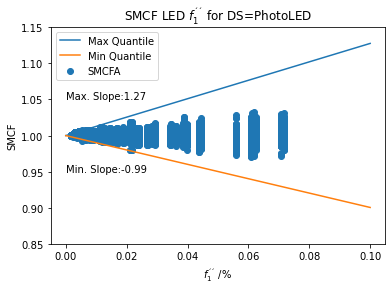

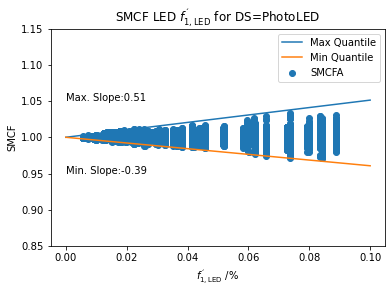

No handles with labels found to put in legend.


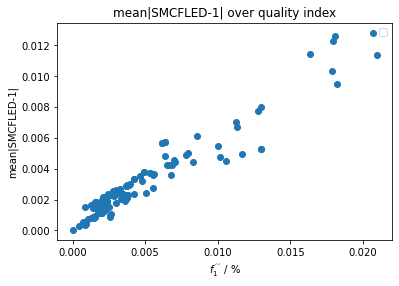

No handles with labels found to put in legend.


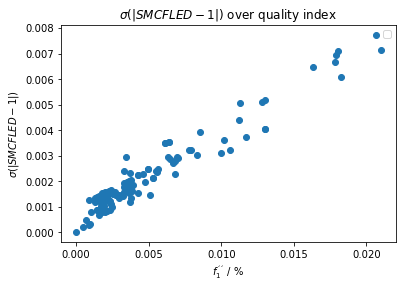

No handles with labels found to put in legend.


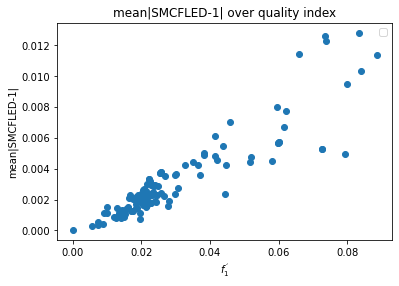

No handles with labels found to put in legend.


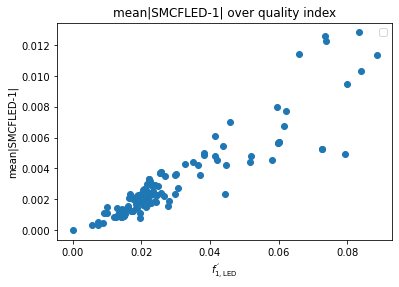

In [22]:
vldetectors = _RES['CIES025_VLDetectors']['S']['data'].copy()
SPD_PTLED = _SPD['CIES025_PTLED']['S']['data'].copy()
SPD_PhotoLED = _SPD['PHOTOLED']['S']['data'].copy()

f1pA=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
f1pLED=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
f1pp=py_f1PrimeGlx(vldetectors, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=dCutOff, dBandWidth=0.)

SMCF_PTLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( SPD_PTLED, vldetectors, S_C='A')
SMCFLED_PTLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( SPD_PTLED, vldetectors, S_C='LED_B3')

SMCF_PhotoLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( SPD_PhotoLED, vldetectors, S_C='A')
SMCFLED_PhotoLED=lx.spectral_mismatch_and_uncertainty.get_spectral_mismatch_correction_factors( SPD_PhotoLED, vldetectors, S_C='LED_B3')

SMCF = SMCFLED_PTLED

f1pMinMaxScatter( SMCF, 342*f1pp,
                  title='SMCF LED $f_{1}^{´´}$ for DS=PhotoLED',
                  xlabel='$f_{1}^{´´}$ /%', ylabel='SMCF', filename='f1pp_SMCF.png')
plt.show()

f1pMinMaxScatter( SMCF, f1pLED,
                  title='SMCF LED $f_{1, \mathrm{LED}}^{´}$ for DS=PhotoLED',
                  xlabel='$f_{1,\mathrm{LED}}^{´}$ /%', ylabel='SMCF', filename='f1pLED_SMCF.png')
plt.show()

meanfield = np.mean(abs(SMCF-1), axis=0)
stdfield = np.std(abs(SMCF-1), axis=0)

strTitleMean = 'mean|SMCFLED-1| over quality index'
strTitleStd = '$\sigma(|SMCFLED-1|)$ over quality index'
scatterPlot( 100*f1pp, meanfield, title=strTitleMean, xlabel='$f_{1}^{´´}$ / %', ylabel='mean|SMCFLED-1|', filename='')
scatterPlot( 100*f1pp, stdfield, title=strTitleStd, xlabel='$f_{1}^{´´}$ / %', ylabel='$\sigma(|SMCFLED-1|)$', filename='')
scatterPlot( f1pA, meanfield, title=strTitleMean, xlabel='$f_{1}^{´}$', ylabel='mean|SMCFLED-1|', filename='')
scatterPlot( f1pLED, meanfield, title=strTitleMean, xlabel='$f_{1,\mathrm{LED}}^{´}$', ylabel='mean|SMCFLED-1|', filename='')

<ipython-input-23-516a195aa444>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(f1pA/f1pp)


762.6270041455543

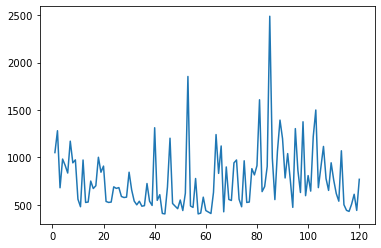

In [23]:
plt.plot(f1pA/f1pp)
index = np.where(f1pp>0)
np.mean(f1pA[index]/f1pp[index])